In [2]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [3]:
import os, glob

base = "/content/drive/MyDrive/coreset_experiments"
print("Exists?", os.path.exists(base))
print("\nFiles in coreset_experiments (first 50):")
for f in sorted(glob.glob(base + "/*"))[:50]:
    print(os.path.basename(f))


Exists? True

Files in coreset_experiments (first 50):
runs_full_datasets_smallgrid.csv
runs_fullgrid.csv
runs_fullgridPart2.csv
runs_fullgridPart2Attempt2.csv
runs_fullgridcovertype.csv
runs_fullgridmnist.csv
runs_smallgrid.csv



DATASET: adult
Rows in file used: 750
k values: [2, 5, 10, 50, 100]
m/k values: [2.0, 5.0, 10.0, 50.0, 100.0]

Count summary per (algorithm, k):


,algorithm,k,min,max,sum,num_points
0,kmeans,2,10,10,50,5
1,kmeans,5,10,10,50,5
2,kmeans,10,10,10,50,5
3,kmeans,50,10,10,50,5
4,kmeans,100,10,10,50,5
5,localsearch,2,10,10,50,5
6,localsearch,5,10,10,50,5
7,localsearch,10,10,10,50,5
8,localsearch,50,10,10,50,5
9,localsearch,100,10,10,50,5


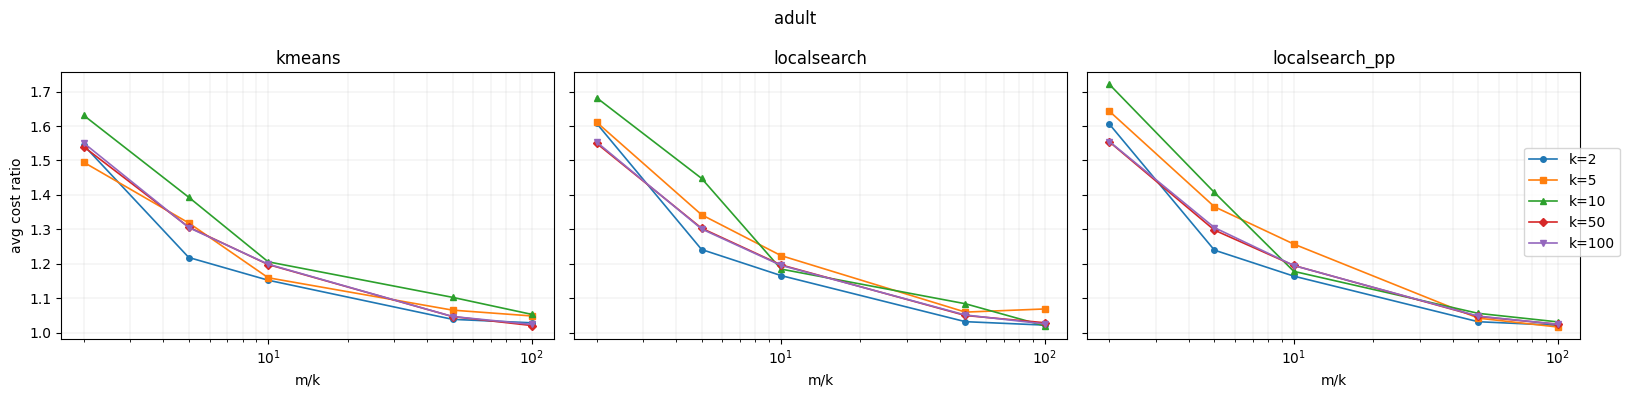


DATASET: mnist
Rows in file used: 480
k values: [2, 5, 10, 50]
m/k values: [2.0, 5.0, 10.0, 50.0]

Count summary per (algorithm, k):


,algorithm,k,min,max,sum,num_points
0,kmeans,2,10,10,40,4
1,kmeans,5,10,10,40,4
2,kmeans,10,10,10,40,4
3,kmeans,50,10,10,40,4
4,localsearch,2,10,10,40,4
5,localsearch,5,10,10,40,4
6,localsearch,10,10,10,40,4
7,localsearch,50,10,10,40,4
8,localsearch_pp,2,10,10,40,4
9,localsearch_pp,5,10,10,40,4


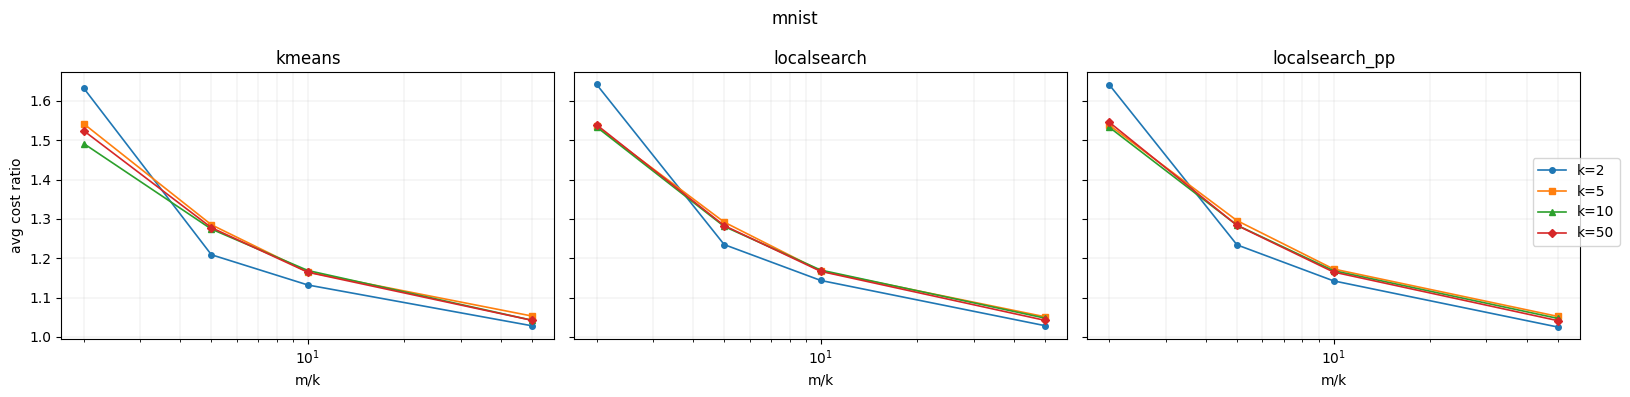


DATASET: covtype
Rows in file used: 480
k values: [2, 5, 10, 50]
m/k values: [2.0, 5.0, 10.0, 50.0]

Count summary per (algorithm, k):


,algorithm,k,min,max,sum,num_points
0,kmeans,2,10,10,40,4
1,kmeans,5,10,10,40,4
2,kmeans,10,10,10,40,4
3,kmeans,50,10,10,40,4
4,localsearch,2,10,10,40,4
5,localsearch,5,10,10,40,4
6,localsearch,10,10,10,40,4
7,localsearch,50,10,10,40,4
8,localsearch_pp,2,10,10,40,4
9,localsearch_pp,5,10,10,40,4


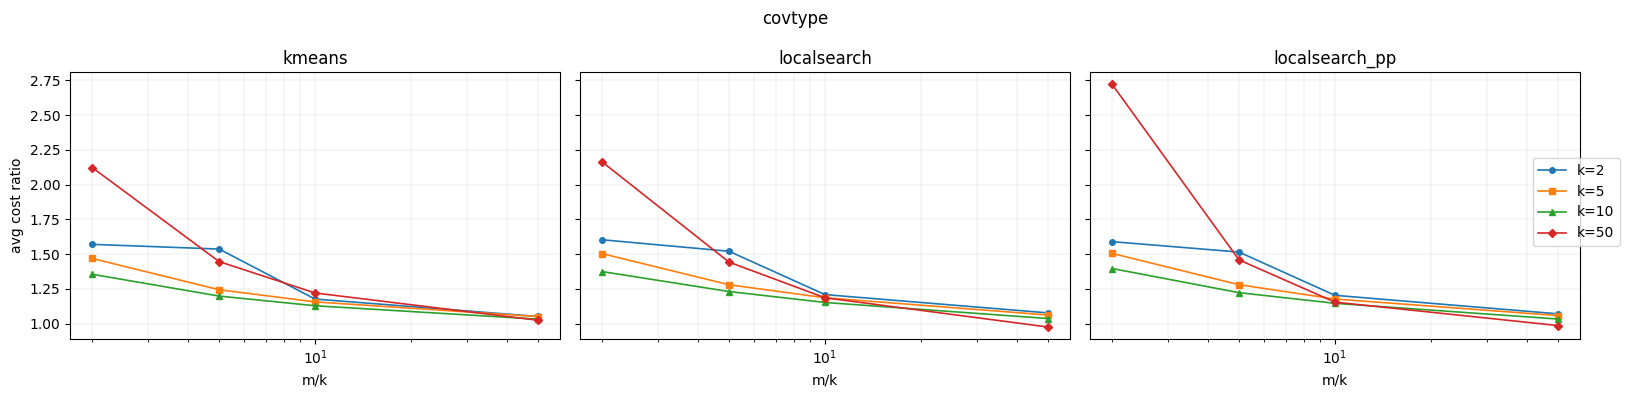

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FILES = {
    "adult": "/content/drive/MyDrive/coreset_experiments/runs_fullgrid.csv",
    "mnist": "/content/drive/MyDrive/coreset_experiments/runs_fullgridmnist.csv",
    "covtype": "/content/drive/MyDrive/coreset_experiments/runs_fullgridcovertype.csv",  # maybe missing .csv
}

ALG_ORDER = ["kmeans", "localsearch", "localsearch_pp"]
MARKERS = ["o","s","^","D","v","P","X","*","+","x"]

def read_csv_smart(path):
    if os.path.exists(path):
        return pd.read_csv(path)
    if os.path.exists(path + ".csv"):
        return pd.read_csv(path + ".csv")
    raise FileNotFoundError(f"Could not find: {path} or {path+'.csv'}")

def prep_df(df, dataset_name=None):
    df = df.copy()
    # If the file contains multiple datasets, filter. Otherwise keep all rows.
    if dataset_name is not None and "dataset" in df.columns:
        df = df[df["dataset"] == dataset_name].copy()

    # Basic sanity
    for col in ["k", "m", "ratio"]:
        if col not in df.columns:
            raise ValueError(f"Missing required column '{col}'. Columns are: {df.columns.tolist()}")

    if "m_over_k" not in df.columns:
        df["m_over_k"] = df["m"] / df["k"]

    # clean
    df = df.dropna(subset=["ratio", "k", "m", "m_over_k"])
    df["k"] = df["k"].astype(int)
    df["m"] = df["m"].astype(int)

    # If algorithm column missing, assume everything is one algorithm named "kmeans"
    if "algorithm" not in df.columns:
        df["algorithm"] = "kmeans"

    return df

def summarize_counts(agg):
    # agg has columns: algorithm, k, m_over_k, mean, std, count
    s = (agg.groupby(["algorithm","k"])["count"]
         .agg(["min","max","sum","count"])
         .reset_index()
         .rename(columns={"count":"num_points"}))
    return s

def plot_dataset_k_collapse(dataset_name, path):
    df = read_csv_smart(path)
    df = prep_df(df, dataset_name=dataset_name)

    # aggregate: mean/std/count per (algorithm, k, m_over_k)
    agg = (df.groupby(["algorithm","k","m_over_k"], as_index=False)["ratio"]
           .agg(mean="mean", std="std", count="count"))

    # print count summaries first (as requested)
    print("\n==============================")
    print(f"DATASET: {dataset_name}")
    print("Rows in file used:", len(df))
    print("k values:", sorted(df["k"].unique().tolist()))
    print("m/k values:", sorted(df["m_over_k"].unique().tolist()))

    count_summary = summarize_counts(agg)
    print("\nCount summary per (algorithm, k):")
    display(count_summary.sort_values(["algorithm","k"]))

    # Plot: 3 subplots (one per algorithm), curves per k
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

    for ax, alg in zip(axes, ALG_ORDER):
        sub = agg[agg["algorithm"] == alg].copy()
        if sub.empty:
            ax.set_title(f"{alg} (no data)")
            ax.set_xscale("log")
            ax.grid(True, which="both", linewidth=0.3, alpha=0.5)
            continue

        ks = sorted(sub["k"].unique().tolist())
        for i, k in enumerate(ks):
            s2 = sub[sub["k"] == k].sort_values("m_over_k")
            ax.plot(
                s2["m_over_k"], s2["mean"],
                marker=MARKERS[i % len(MARKERS)],
                linewidth=1.2,
                markersize=4,
                label=f"k={k}"
            )

        ax.set_xscale("log")
        ax.set_xlabel("m/k")
        ax.set_title(alg)
        ax.grid(True, which="both", linewidth=0.3, alpha=0.5)

    axes[0].set_ylabel("avg cost ratio")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.02, 0.5))
    fig.suptitle(dataset_name)
    plt.tight_layout()
    plt.show()

# Run for all three datasets
for name, path in FILES.items():
    plot_dataset_k_collapse(name, path)



DATASET: adult
Total rows used: 750
k values present: [2, 5, 10, 50, 100]
m/k values present: [2.0, 5.0, 10.0, 50.0, 100.0]

Counts per (algorithm, m/k):


,algorithm,m_over_k,count
0,kmeans,2.0,50
1,kmeans,5.0,50
2,kmeans,10.0,50
3,kmeans,50.0,50
4,kmeans,100.0,50
5,localsearch,2.0,50
6,localsearch,5.0,50
7,localsearch,10.0,50
8,localsearch,50.0,50
9,localsearch,100.0,50


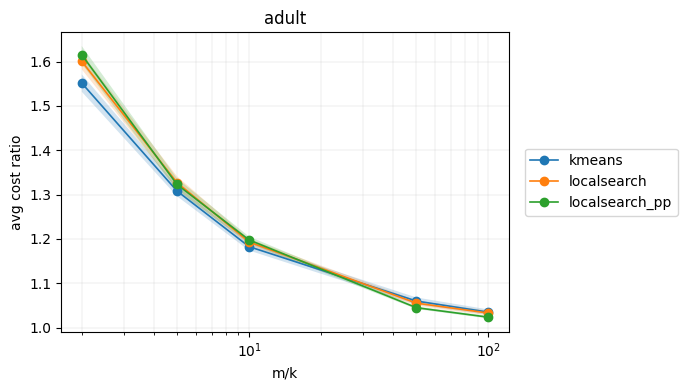


DATASET: mnist
Total rows used: 480
k values present: [2, 5, 10, 50]
m/k values present: [2.0, 5.0, 10.0, 50.0]

Counts per (algorithm, m/k):


,algorithm,m_over_k,count
0,kmeans,2.0,40
1,kmeans,5.0,40
2,kmeans,10.0,40
3,kmeans,50.0,40
4,localsearch,2.0,40
5,localsearch,5.0,40
6,localsearch,10.0,40
7,localsearch,50.0,40
8,localsearch_pp,2.0,40
9,localsearch_pp,5.0,40


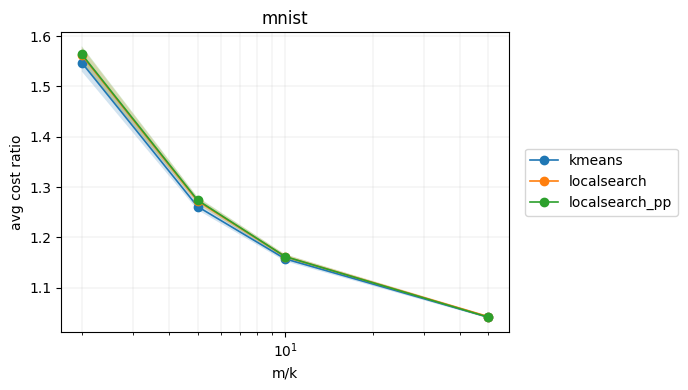


DATASET: covtype
Total rows used: 480
k values present: [2, 5, 10, 50]
m/k values present: [2.0, 5.0, 10.0, 50.0]

Counts per (algorithm, m/k):


,algorithm,m_over_k,count
0,kmeans,2.0,40
1,kmeans,5.0,40
2,kmeans,10.0,40
3,kmeans,50.0,40
4,localsearch,2.0,40
5,localsearch,5.0,40
6,localsearch,10.0,40
7,localsearch,50.0,40
8,localsearch_pp,2.0,40
9,localsearch_pp,5.0,40


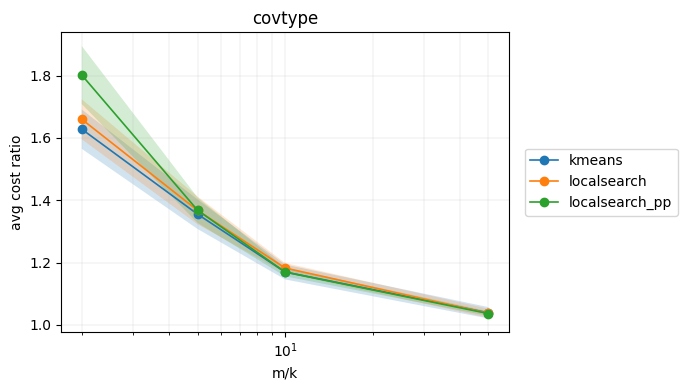

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- paths (adjust if needed) ----
FILES = {
    "adult":   "/content/drive/MyDrive/coreset_experiments/runs_fullgrid.csv",
    "mnist":   "/content/drive/MyDrive/coreset_experiments/runs_fullgridmnist.csv",
    "covtype": "/content/drive/MyDrive/coreset_experiments/runs_fullgridcovertype",  # maybe missing .csv
}

ALG_ORDER = ["kmeans", "localsearch", "localsearch_pp"]

def read_csv_smart(path):
    if os.path.exists(path):
        return pd.read_csv(path)
    if os.path.exists(path + ".csv"):
        return pd.read_csv(path + ".csv")
    raise FileNotFoundError(f"Could not find: {path} or {path+'.csv'}")

def prep_df(df, dataset_name):
    df = df.copy()
    # If file contains multiple datasets, filter; otherwise keep all.
    if "dataset" in df.columns:
        df = df[df["dataset"] == dataset_name].copy()

    for col in ["k", "m", "ratio"]:
        if col not in df.columns:
            raise ValueError(f"Missing column '{col}'. Found: {df.columns.tolist()}")

    if "algorithm" not in df.columns:
        df["algorithm"] = "kmeans"

    if "m_over_k" not in df.columns:
        df["m_over_k"] = df["m"] / df["k"]

    df = df.dropna(subset=["algorithm", "k", "m", "m_over_k", "ratio"])
    df["k"] = df["k"].astype(int)
    df["m"] = df["m"].astype(int)
    df["m_over_k"] = df["m_over_k"].astype(float)
    df["ratio"] = df["ratio"].astype(float)
    return df

def plot_one_dataset(dataset_name, path, band="sem"):
    """
    band: None, "std", or "sem"
      - std: mean ± 1 standard deviation of ratio over all runs at that (alg, m/k)
      - sem: mean ± standard error = std / sqrt(count)
    """
    df_raw = read_csv_smart(path)
    df = prep_df(df_raw, dataset_name)

    if df.empty:
        print(f"[{dataset_name}] No rows found.")
        return

    # Aggregate over ALL k and trials for each (algorithm, m/k)
    agg = (df.groupby(["algorithm", "m_over_k"], as_index=False)["ratio"]
             .agg(mean="mean", std="std", var="var", count="count"))
    agg["sem"] = agg["std"] / np.sqrt(np.maximum(1, agg["count"]))

    # Print counts (as you requested)
    print("\n==============================")
    print(f"DATASET: {dataset_name}")
    print("Total rows used:", len(df))
    print("k values present:", sorted(df["k"].unique().tolist()))
    print("m/k values present:", sorted(df["m_over_k"].unique().tolist()))
    print("\nCounts per (algorithm, m/k):")
    display(agg.sort_values(["algorithm", "m_over_k"])[["algorithm", "m_over_k", "count"]])

    # Plot: single axes, 3 algorithms in different colors (default matplotlib cycle)
    plt.figure(figsize=(7,4))
    for alg in ALG_ORDER:
        a = agg[agg["algorithm"] == alg].sort_values("m_over_k")
        if a.empty:
            continue

        plt.plot(a["m_over_k"], a["mean"], marker="o", linewidth=1.2, label=alg)

        if band in ("std", "sem") and len(a) > 1:
            spread = a[band].to_numpy()
            plt.fill_between(a["m_over_k"], a["mean"] - spread, a["mean"] + spread, alpha=0.2)

    plt.xscale("log")
    plt.xlabel("m/k")
    plt.ylabel("avg cost ratio")
    plt.title(dataset_name)
    plt.grid(True, which="both", linewidth=0.3, alpha=0.5)
    plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout()
    plt.show()

# ---- run plots (choose band=None / "std" / "sem") ----
for name, path in FILES.items():
    plot_one_dataset(name, path, band="sem")


In [8]:
from google.colab import drive
drive.mount("/content/drive")

FILES = {
    "adult":   "/content/drive/MyDrive/coreset_experiments/runs_fullgrid.csv",
    "mnist":   "/content/drive/MyDrive/coreset_experiments/runs_fullgridmnist.csv",
    "covtype": "/content/drive/MyDrive/coreset_experiments/runs_fullgridcovertype",  # maybe missing .csv
}

BASELINE_OUT = {
    "adult":   "/content/drive/MyDrive/coreset_experiments/baseline_full_adult.csv",
    "mnist":   "/content/drive/MyDrive/coreset_experiments/baseline_full_mnist.csv",
    "covtype": "/content/drive/MyDrive/coreset_experiments/baseline_full_covtype.csv",
}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_covtype, fetch_openml
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

ALG_ORDER = ["kmeans", "localsearch", "localsearch_pp"]

def read_csv_smart(path):
    if os.path.exists(path): return pd.read_csv(path)
    if os.path.exists(path + ".csv"): return pd.read_csv(path + ".csv")
    raise FileNotFoundError(f"Could not find: {path} or {path+'.csv'}")

def load_covtype_full(scale=True):
    X, _ = fetch_covtype(return_X_y=True)
    X = X.astype(np.float32)
    if scale:
        X = StandardScaler().fit_transform(X).astype(np.float32)
    return X

def load_mnist_full(center=True):
    X, _ = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
    X = (X.astype(np.float32) / 255.0)
    if center:
        X = (X - X.mean(axis=0, keepdims=True)).astype(np.float32)
    return X

def load_adult_full():
    X_df, _ = fetch_openml("adult", version=2, return_X_y=True, as_frame=True)
    cat_cols = X_df.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = [c for c in X_df.columns if c not in cat_cols]
    pre = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ],
        remainder="drop",
        sparse_threshold=0.0,
    )
    return pre.fit_transform(X_df).astype(np.float32)

def kmeans_cost_full(X, centers, batch=50000):
    X = np.asarray(X, dtype=np.float32)
    C = np.asarray(centers, dtype=np.float32)
    total = 0.0
    for i in range(0, X.shape[0], batch):
        Xi = X[i:i+batch]
        d2 = ((Xi[:, None, :] - C[None, :, :]) ** 2).sum(axis=2)
        total += d2.min(axis=1).sum()
    return float(total)

def lloyd_steps(X, k, init_centers, iters=10, seed=0):
    km = KMeans(n_clusters=k, init=np.asarray(init_centers, dtype=np.float32),
                n_init=1, max_iter=iters, random_state=seed, algorithm="lloyd")
    km.fit(X)
    return km.cluster_centers_

def dist2_to_centers(X, centers):
    return ((X[:, None, :] - centers[None, :, :]) ** 2).sum(axis=2)

def d2_sample_point(X, centers, rng, weights=None):
    n = X.shape[0]
    if centers is None or len(centers) == 0:
        return X[rng.integers(n)]
    d2 = dist2_to_centers(X, centers).min(axis=1)
    probs = d2 / (d2.sum() + 1e-12)
    return X[rng.choice(n, p=probs)]

def best_single_swap(centers, cand, X_eval, rng, try_centers="all"):
    k = centers.shape[0]
    d2_all = dist2_to_centers(X_eval, centers)
    idx1 = np.argmin(d2_all, axis=1)
    d1 = d2_all[np.arange(d2_all.shape[0]), idx1]
    part = np.partition(d2_all, kth=1, axis=1)
    d2_second = part[:, 1]
    cand_d2 = ((X_eval - cand) ** 2).sum(axis=1)

    if try_centers == "all" or (isinstance(try_centers, int) and try_centers >= k):
        J = np.arange(k)
    else:
        J = rng.choice(k, size=int(try_centers), replace=False)

    base = d1.sum()
    best_j, best_cost = None, base
    for j in J:
        fallback = np.where(idx1 == j, d2_second, d1)
        new_d = np.minimum(fallback, cand_d2)
        c = new_d.sum()
        if c < best_cost:
            best_cost, best_j = c, int(j)
    return best_j

def kmeanspp_seed(X, k, seed=0):
    rng = np.random.default_rng(seed)
    centers = [d2_sample_point(X, None, rng)]
    while len(centers) < k:
        centers.append(d2_sample_point(X, np.asarray(centers), rng))
    return np.asarray(centers, dtype=np.float32)

def localsearch_seed(X, k, seed=0, iters=30, eval_n=20000, try_centers="all"):
    rng = np.random.default_rng(seed)
    centers = kmeanspp_seed(X, k, seed=seed)

    n = X.shape[0]
    idx = rng.choice(n, size=min(eval_n, n), replace=False)
    X_eval = X[idx]

    for _ in range(iters):
        cand = X[rng.integers(n)]  # uniform candidate
        j = best_single_swap(centers, cand, X_eval, rng, try_centers=try_centers)
        if j is not None:
            centers[j] = cand
    return centers

def localsearchpp_seed(X, k, seed=0, extra_rounds=50, eval_n=20000, try_centers="all"):
    rng = np.random.default_rng(seed)
    centers = kmeanspp_seed(X, k, seed=seed)

    n = X.shape[0]
    idx = rng.choice(n, size=min(eval_n, n), replace=False)
    X_eval = X[idx]

    for _ in range(extra_rounds):
        cand = d2_sample_point(X, centers, rng)  # D^2 candidate
        j = best_single_swap(centers, cand, X_eval, rng, try_centers=try_centers)
        if j is not None:
            centers[j] = cand
    return centers

def full_run_time_seconds(X, algo, k, trial, params, lloyd_iters=10):
    # Time: (init + Lloyd + evaluation on full X), so it’s comparable to your coreset `seconds`.
    t0 = time.time()
    if algo == "kmeans":
        init = kmeanspp_seed(X, k, seed=trial)
    elif algo == "localsearch":
        init = localsearch_seed(X, k, seed=trial,
                                iters=params.get("ls_iters", 30),
                                eval_n=params.get("ls_eval_n", 20000),
                                try_centers=params.get("ls_try_centers", "all"))
    else:
        init = localsearchpp_seed(X, k, seed=trial,
                                  extra_rounds=params.get("lspp_extra_rounds", 50),
                                  eval_n=params.get("lspp_eval_n", 20000),
                                  try_centers=params.get("lspp_try_centers", "all"))
    centers = lloyd_steps(X, k, init, iters=lloyd_iters, seed=trial)
    _ = kmeans_cost_full(X, centers)  # include eval time
    return float(time.time() - t0)


In [10]:
def build_baseline_for_dataset(dataset_name, X, runs_path, out_path):
    df = read_csv_smart(runs_path)
    if "dataset" in df.columns:
        df = df[df["dataset"] == dataset_name].copy()
    if df.empty:
        print(f"[{dataset_name}] no rows in {runs_path}")
        return

    # Unique keys we need baselines for
    keys = df[["algorithm","k","trial",
               "ls_iters","ls_eval_n","ls_try_centers",
               "lspp_extra_rounds","lspp_eval_n","lspp_try_centers",
               "lloyd_iters"]].drop_duplicates()

    # If baseline file exists, skip already computed keys
    done = set()
    if os.path.exists(out_path):
        base = pd.read_csv(out_path)
        for r in base.itertuples(index=False):
            done.add((r.algorithm, int(r.k), int(r.trial), int(r.lloyd_iters)))

    rows = []
    for r in keys.itertuples(index=False):
        key = (r.algorithm, int(r.k), int(r.trial), int(r.lloyd_iters))
        if key in done:
            continue

        params = dict(
            ls_iters=int(r.ls_iters),
            ls_eval_n=int(r.ls_eval_n),
            ls_try_centers=str(r.ls_try_centers),
            lspp_extra_rounds=int(r.lspp_extra_rounds),
            lspp_eval_n=int(r.lspp_eval_n),
            lspp_try_centers=str(r.lspp_try_centers),
        )
        sec = full_run_time_seconds(X, r.algorithm, int(r.k), int(r.trial), params, lloyd_iters=int(r.lloyd_iters))
        rows.append(dict(dataset=dataset_name, algorithm=r.algorithm, k=int(r.k), trial=int(r.trial),
                         lloyd_iters=int(r.lloyd_iters), seconds_full=sec))
        print("baseline logged:", dataset_name, r.algorithm, "k=", int(r.k), "trial=", int(r.trial), "sec=", sec)

        # append incrementally
        pd.DataFrame([rows[-1]]).to_csv(out_path, mode="a", header=not os.path.exists(out_path), index=False)

    print(f"[{dataset_name}] baseline file:", out_path)


In [13]:
def plot_speedup_dataset(dataset_name, runs_path, baseline_path, band="iqr"):
    df = read_csv_smart(runs_path)
    if "dataset" in df.columns:
        df = df[df["dataset"] == dataset_name].copy()
    if df.empty:
        print(f"[{dataset_name}] no run rows")
        return

    base = pd.read_csv(baseline_path)
    base = base[base["dataset"] == dataset_name].copy()
    if base.empty:
        print(f"[{dataset_name}] no baseline rows yet")
        return

    if "m_over_k" not in df.columns:
        df["m_over_k"] = df["m"] / df["k"]

    # merge baseline onto each coreset run row
    merged = df.merge(base, on=["algorithm","k","trial","lloyd_iters"], how="inner")
    merged["speedup"] = merged["seconds_full"] / merged["seconds"]

    # counts first (your disclaimer)
    cnt = merged.groupby(["algorithm","m_over_k"], as_index=False).size().rename(columns={"size":"count"})
    print("\n==============================")
    print("DATASET:", dataset_name)
    print("Rows used after join:", len(merged))
    display(cnt.sort_values(["algorithm","m_over_k"]))

    # summary for plotting
    g = merged.groupby(["algorithm","m_over_k"])["speedup"]
    if band == "sem":
        agg = g.agg(mean="mean", std="std", count="count").reset_index()
        agg["lo"] = agg["mean"] - agg["std"]/np.sqrt(np.maximum(1, agg["count"]))
        agg["hi"] = agg["mean"] + agg["std"]/np.sqrt(np.maximum(1, agg["count"]))
        ycol = "mean"
    else:
        agg = g.agg(med="median",
                    q25=lambda s: s.quantile(0.25),
                    q75=lambda s: s.quantile(0.75),
                    count="count").reset_index()
        agg["lo"] = agg["q25"]; agg["hi"] = agg["q75"]
        ycol = "med"

    plt.figure(figsize=(7,4))
    for alg in ALG_ORDER:
        a = agg[agg["algorithm"] == alg].sort_values("m_over_k")
        if a.empty:
            continue
        plt.plot(a["m_over_k"], a[ycol], marker="o", linewidth=1.2, label=alg)
        plt.fill_between(a["m_over_k"], a["lo"], a["hi"], alpha=0.2)

    plt.xscale("log")
    plt.xlabel("m/k")
    plt.ylabel("speedup (seconds_full / seconds_coreset)")
    plt.title(dataset_name)
    plt.grid(True, which="both", linewidth=0.3, alpha=0.5)
    plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout()
    plt.show()


In [14]:
# Load datasets (full)
X_adult  = load_adult_full()
X_mnist  = load_mnist_full(center=True)
X_cov    = load_covtype_full(scale=True)

DATA = {
    "adult": (X_adult,  FILES["adult"],  BASELINE_OUT["adult"]),
    "mnist": (X_mnist,  FILES["mnist"],  BASELINE_OUT["mnist"]),
    "covtype": (X_cov,  FILES["covtype"], BASELINE_OUT["covtype"]),
}

for name, (X, run_path, base_path) in DATA.items():
    build_baseline_for_dataset(name, X, run_path, base_path)
    plot_speedup_dataset(name, run_path, base_path, band="iqr")  # or band="sem"


baseline logged: adult kmeans k= 2 trial= 0 sec= 0.230912446975708
baseline logged: adult localsearch k= 2 trial= 0 sec= 0.6442408561706543
baseline logged: adult localsearch_pp k= 2 trial= 0 sec= 2.251617670059204
baseline logged: adult kmeans k= 2 trial= 1 sec= 0.1417098045349121
baseline logged: adult localsearch k= 2 trial= 1 sec= 0.6369221210479736
baseline logged: adult localsearch_pp k= 2 trial= 1 sec= 2.762345790863037
baseline logged: adult kmeans k= 2 trial= 2 sec= 0.1975092887878418
baseline logged: adult localsearch k= 2 trial= 2 sec= 0.8513166904449463
baseline logged: adult localsearch_pp k= 2 trial= 2 sec= 2.394148349761963
baseline logged: adult kmeans k= 2 trial= 3 sec= 0.14435911178588867
baseline logged: adult localsearch k= 2 trial= 3 sec= 0.6302282810211182
baseline logged: adult localsearch_pp k= 2 trial= 3 sec= 2.270714521408081
baseline logged: adult kmeans k= 2 trial= 4 sec= 0.14301848411560059
baseline logged: adult localsearch k= 2 trial= 4 sec= 0.64457321166

KeyboardInterrupt: 


DATASET: adult
Run rows: 750
Baseline rows: 125
Rows after join (used for plot): 625


,algorithm,m_over_k,count
0,kmeans,2.0,42
1,kmeans,5.0,42
2,kmeans,10.0,42
3,kmeans,50.0,42
4,kmeans,100.0,42
5,localsearch,2.0,42
6,localsearch,5.0,42
7,localsearch,10.0,42
8,localsearch,50.0,42
9,localsearch,100.0,42


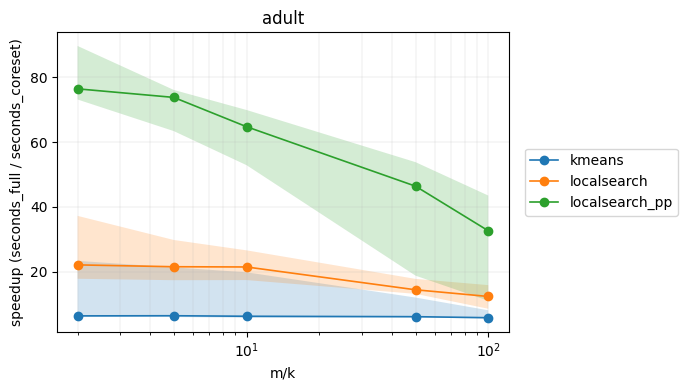

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ALG_ORDER = ["kmeans", "localsearch", "localsearch_pp"]

def read_csv_smart(path):
    if os.path.exists(path): return pd.read_csv(path)
    if os.path.exists(path + ".csv"): return pd.read_csv(path + ".csv")
    raise FileNotFoundError(f"Could not find: {path} or {path+'.csv'}")

def plot_speedup_dataset_partial(dataset_name, runs_path, baseline_path, band="iqr"):
    df = read_csv_smart(runs_path)
    if "dataset" in df.columns:
        df = df[df["dataset"] == dataset_name].copy()
    if df.empty:
        print(f"[{dataset_name}] no run rows")
        return

    base = read_csv_smart(baseline_path)
    if "dataset" in base.columns:
        base = base[base["dataset"] == dataset_name].copy()
    if base.empty:
        print(f"[{dataset_name}] no baseline rows yet")
        return

    if "m_over_k" not in df.columns:
        df["m_over_k"] = df["m"] / df["k"]

    merged = df.merge(base, on=["algorithm","k","trial","lloyd_iters"], how="inner")
    merged = merged.dropna(subset=["seconds","seconds_full","m_over_k"])
    merged["speedup"] = merged["seconds_full"] / merged["seconds"]

    print("\n==============================")
    print("DATASET:", dataset_name)
    print("Run rows:", len(df))
    print("Baseline rows:", len(base))
    print("Rows after join (used for plot):", len(merged))

    # counts at each point
    cnt = (merged.groupby(["algorithm","m_over_k"], as_index=False)
                 .size().rename(columns={"size":"count"}))
    display(cnt.sort_values(["algorithm","m_over_k"]))

    g = merged.groupby(["algorithm","m_over_k"])["speedup"]

    if band == "sem":
        agg = g.agg(mean="mean", std="std", count="count").reset_index()
        agg["lo"] = agg["mean"] - agg["std"]/np.sqrt(np.maximum(1, agg["count"]))
        agg["hi"] = agg["mean"] + agg["std"]/np.sqrt(np.maximum(1, agg["count"]))
        ycol = "mean"
    else:  # iqr
        agg = g.agg(med="median",
                    q25=lambda s: s.quantile(0.25),
                    q75=lambda s: s.quantile(0.75),
                    count="count").reset_index()
        agg["lo"] = agg["q25"]; agg["hi"] = agg["q75"]
        ycol = "med"

    plt.figure(figsize=(7,4))
    for alg in ALG_ORDER:
        a = agg[agg["algorithm"] == alg].sort_values("m_over_k")
        if a.empty:
            continue
        plt.plot(a["m_over_k"], a[ycol], marker="o", linewidth=1.2, label=alg)
        plt.fill_between(a["m_over_k"], a["lo"], a["hi"], alpha=0.2)

    plt.xscale("log")
    plt.xlabel("m/k")
    plt.ylabel("speedup (seconds_full / seconds_coreset)")
    plt.title(dataset_name + "")
    plt.grid(True, which="both", linewidth=0.3, alpha=0.5)
    plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout()
    plt.show()

# ---- fill these with your paths ----
dataset_name = "adult"
runs_path = "/content/drive/MyDrive/coreset_experiments/runs_fullgrid.csv"
baseline_path = "/content/drive/MyDrive/coreset_experiments/baseline_full_adult.csv"

plot_speedup_dataset_partial(dataset_name, runs_path, baseline_path, band="iqr")


In [29]:
import os
import pandas as pd
import numpy as np

# ---- EDIT THESE ----
FILES = {
    "adult":   "/content/drive/MyDrive/coreset_experiments/runs_fullgrid.csv",
    "mnist":   "/content/drive/MyDrive/coreset_experiments/runs_fullgridmnist.csv",
    "covtype": "/content/drive/MyDrive/coreset_experiments/runs_fullgridcovertype",  # maybe missing .csv
}
KM_PAIRS = [(2, 10), (5, 50), (10, 100), (50, 500)]  # rows to show
# --------------------

ALG_ORDER = ["kmeans", "localsearch", "localsearch_pp"]

def read_csv_smart(path):
    if os.path.exists(path):
        return pd.read_csv(path)
    if os.path.exists(path + ".csv"):
        return pd.read_csv(path + ".csv")
    raise FileNotFoundError(f"Could not find: {path} or {path+'.csv'}")

def make_table_df(dataset_name, path, km_pairs):
    df = read_csv_smart(path)
    if "dataset" in df.columns:
        df = df[df["dataset"] == dataset_name].copy()

    df = df[df["algorithm"].isin(ALG_ORDER)].copy()
    rows = []
    for (k, m) in km_pairs:
        sub = df[(df["k"] == k) & (df["m"] == m)]
        r = {"(k,m)": f"({k},{m})"}
        for alg in ALG_ORDER:
            vals = sub[sub["algorithm"] == alg]["cost_core"]
            r[alg] = float(vals.mean()) if len(vals) else np.nan
        rows.append(r)
    return pd.DataFrame(rows, columns=["(k,m)"] + ALG_ORDER)

def df_to_latex_table(df, caption, label):
    # Format numbers: scientific notation; NaN -> --
    df_fmt = df.copy()
    for c in df_fmt.columns[1:]:
        df_fmt[c] = df_fmt[c].apply(lambda x: "--" if pd.isna(x) else f"{x:.3e}")
    latex_body = df_fmt.to_latex(index=False, escape=False)

    return (
        "\\begin{table}[ht]\n"
        "\\centering\n"
        f"{latex_body}\n"
        f"\\caption{{{caption}}}\n"
        f"\\label{{{label}}}\n"
        "\\end{table}\n"
    )

for name, path in FILES.items():
    df_tbl = make_table_df(name, path, KM_PAIRS)
    caption = "Cost on the scaled dataset (objective evaluated on the full dataset)."
    label = f"tab:{name}-costs"
    latex = df_to_latex_table(df_tbl, caption, label)

    print(f"\n===== LaTeX for {name} =====\n")
    print(latex)
    print("\n(Preview table as DataFrame)\n")
    display(df_tbl)



===== LaTeX for adult =====

\begin{table}[ht]
\centering
\begin{tabular}{llll}
\toprule
(k,m) & kmeans & localsearch & localsearch_pp \\
\midrule
(2,10) & 5.646e+05 & 5.749e+05 & 5.749e+05 \\
(5,50) & 4.384e+05 & 4.454e+05 & 4.430e+05 \\
(10,100) & 3.536e+05 & 3.438e+05 & 3.360e+05 \\
(50,500) & 2.477e+05 & 2.459e+05 & 2.453e+05 \\
\bottomrule
\end{tabular}

\caption{Cost on the scaled dataset (objective evaluated on the full dataset).}
\label{tab:adult-costs}
\end{table}


(Preview table as DataFrame)



,"(k,m)",kmeans,localsearch,localsearch_pp
0,"(2,10)",564625.750000,574871.800000,574871.800000
1,"(5,50)",438358.878125,445350.390625,442993.356250
2,"(10,100)",353571.700000,343771.921875,336036.168750
3,"(50,500)",247710.670313,245852.209375,245270.878125



===== LaTeX for mnist =====

\begin{table}[ht]
\centering
\begin{tabular}{llll}
\toprule
(k,m) & kmeans & localsearch & localsearch_pp \\
\midrule
(2,10) & 4.183e+06 & 4.281e+06 & 4.282e+06 \\
(5,50) & 3.561e+06 & 3.578e+06 & 3.587e+06 \\
(10,100) & 3.236e+06 & 3.231e+06 & 3.220e+06 \\
(50,500) & 2.530e+06 & 2.527e+06 & 2.522e+06 \\
\bottomrule
\end{tabular}

\caption{Cost on the scaled dataset (objective evaluated on the full dataset).}
\label{tab:mnist-costs}
\end{table}


(Preview table as DataFrame)



,"(k,m)",kmeans,localsearch,localsearch_pp
0,"(2,10)",4183416.775,4280714.450,4282214.050
1,"(5,50)",3561152.850,3578033.400,3586622.100
2,"(10,100)",3235584.875,3230764.875,3219706.275
3,"(50,500)",2530482.700,2527011.325,2522024.150



===== LaTeX for covtype =====

\begin{table}[ht]
\centering
\begin{tabular}{llll}
\toprule
(k,m) & kmeans & localsearch & localsearch_pp \\
\midrule
(2,10) & 4.638e+07 & 4.495e+07 & 4.495e+07 \\
(5,50) & 3.181e+07 & 3.205e+07 & 3.182e+07 \\
(10,100) & 2.723e+07 & 2.760e+07 & 2.747e+07 \\
(50,500) & 8.070e+06 & 7.750e+06 & 5.793e+06 \\
\bottomrule
\end{tabular}

\caption{Cost on the scaled dataset (objective evaluated on the full dataset).}
\label{tab:covtype-costs}
\end{table}


(Preview table as DataFrame)



,"(k,m)",kmeans,localsearch,localsearch_pp
0,"(2,10)",46381959.60,44951771.6,44951771.6
1,"(5,50)",31813773.20,32049194.8,31824180.0
2,"(10,100)",27228730.40,27598115.4,27469357.2
3,"(50,500)",8070077.05,7750119.2,5792764.0
